# Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

The One Hundred Layer Tiramisu paper used a modified version of Camvid, with smaller images and few classes. You can get it from the CamVid directory of this repo:

    git clone https://github.com/alexgkendall/SegNet-Tutorial.git

In [3]:
%ls

README.md           planet/            week_2_download.ipynb
data/               week_1 pets.ipynb  week_2_planet.ipynb
docker_run_command  week_2 SGD.ipynb   week_3-camvid_segmentation.ipynb


In [4]:
path = Path('data/SegNet-Tutorial/CamVid')

In [5]:
path.ls()

[PosixPath('data/SegNet-Tutorial/CamVid/train.txt'),
 PosixPath('data/SegNet-Tutorial/CamVid/test'),
 PosixPath('data/SegNet-Tutorial/CamVid/train'),
 PosixPath('data/SegNet-Tutorial/CamVid/trainannot'),
 PosixPath('data/SegNet-Tutorial/CamVid/valannot'),
 PosixPath('data/SegNet-Tutorial/CamVid/val.txt'),
 PosixPath('data/SegNet-Tutorial/CamVid/val'),
 PosixPath('data/SegNet-Tutorial/CamVid/test.txt'),
 PosixPath('data/SegNet-Tutorial/CamVid/testannot')]

# Data

In [6]:
fnames = get_image_files(path/'val')
fnames[:3]

[PosixPath('data/SegNet-Tutorial/CamVid/val/0016E5_08111.png'),
 PosixPath('data/SegNet-Tutorial/CamVid/val/0016E5_08105.png'),
 PosixPath('data/SegNet-Tutorial/CamVid/val/0016E5_08039.png')]

In [7]:
lbl_names = get_image_files(path/'valannot')
lbl_names[:3]

[PosixPath('data/SegNet-Tutorial/CamVid/valannot/0016E5_08111.png'),
 PosixPath('data/SegNet-Tutorial/CamVid/valannot/0016E5_08105.png'),
 PosixPath('data/SegNet-Tutorial/CamVid/valannot/0016E5_08039.png')]

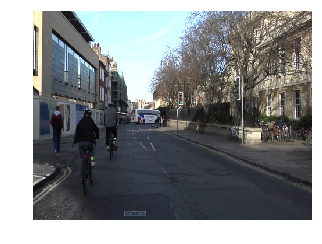

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

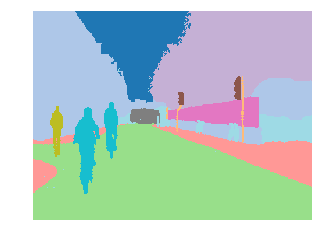

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([360, 480]), tensor([[[ 1,  1,  1,  ...,  5,  5,  5],
          [ 1,  1,  1,  ...,  5,  5,  5],
          [ 1,  1,  1,  ...,  5,  5,  5],
          ...,
          [ 3,  3,  3,  ...,  3,  3,  3],
          [ 3,  3,  3,  ...,  3,  3,  3],
          [ 3,  3,  3,  ...,  3,  3,  3]]]))

# Datasets

In [12]:
bs,size = 8,src_size//2

In [13]:
src = (SegmentationItemList.from_folder(path)
       .split_by_folder(valid='val')
       .label_from_func(get_y_fn, classes=codes))

In [14]:
data = (src.transform(get_transforms(), tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

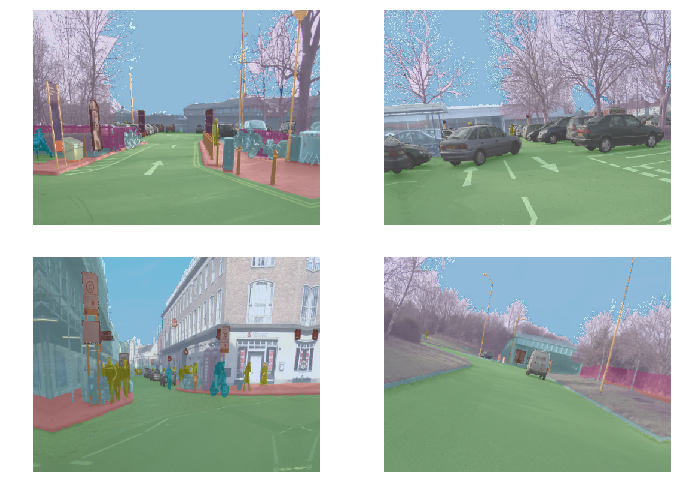

In [15]:
data.show_batch(2, figsize=(10,7))

# Model

In [16]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [17]:
metrics=acc_camvid
wd=1e-2

In [18]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [19]:
lr_find(learn)
learn.recorder.plot()

RuntimeError: Error(s) in loading state_dict for DynamicUnet:
	While copying the parameter named "0.0.weight", whose dimensions in the model are torch.Size([64, 3, 7, 7]) and whose dimensions in the checkpoint are torch.Size([64, 3, 7, 7]).